In [37]:
import os
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler


plt.rcParams["figure.figsize"] = (20, 16)
warnings.simplefilter("ignore")
os.listdir()

['.ipynb_checkpoints', 'analyse.ipynb', 'whats.csv', 'yt.csv', 'yt_whats.csv']

In [2]:
data = pd.read_csv('whats.csv')


def first_preprocess(data) :
    data.sort_values(by="Time", ascending=True,inplace =True)
    data.reset_index(drop=True, inplace = True)
    data["Time"] = pd.to_datetime(data.Time, unit='ms')
    reserved_values = [5, 65534, 65535]
    data=data[~data.rnti.isin(reserved_values)] # on enlève les plages reservées
    return data

data = first_preprocess(data)
data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id
259,2022-10-14 14:02:01.662,80,3709,2.0,51.0,6.0,1,2,-2,296,-2,7,4
261,2022-10-14 14:02:01.677,80,3724,0.0,51.0,6.0,1,24,-2,520,-2,1,4
263,2022-10-14 14:02:01.693,80,3740,0.0,51.0,6.0,1,31,-2,520,-2,1,4
265,2022-10-14 14:02:01.717,80,3764,0.0,51.0,6.0,1,24,-2,520,-2,1,4
267,2022-10-14 14:02:01.737,80,3784,0.0,51.0,6.0,1,24,-2,520,-2,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
31907,2022-10-14 14:04:36.037,81,4484,0.0,32.0,5.0,1,20,-2,840,-2,2,5
31910,2022-10-14 14:04:36.045,81,4492,0.0,32.0,5.0,1,24,-2,520,-2,1,5
31911,2022-10-14 14:04:36.050,81,4497,2.0,32.0,5.0,1,28,-2,712,-2,1,5
31915,2022-10-14 14:04:36.077,81,4524,0.0,32.0,5.0,1,20,-2,840,-2,2,5


In [3]:
data[["rnti","connection_id"]].value_counts()


rnti  connection_id
80    4                20044
81    5                   37
dtype: int64

In [4]:
# pour yt et whats connec ID 4 

<AxesSubplot:>

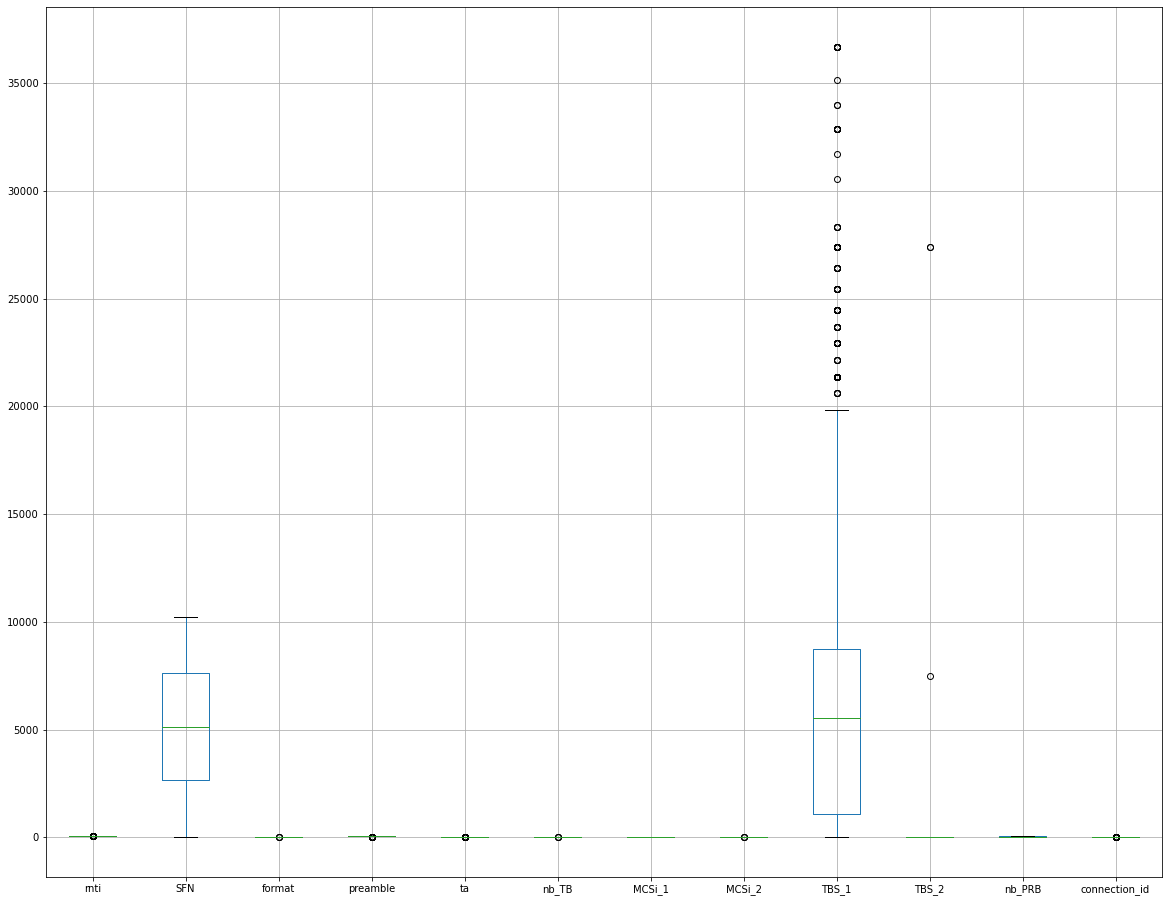

In [5]:
data.boxplot()

In [6]:

def second_preprocess(data) :
    to_concat=[]
    for value in data.connection_id.unique():
        tmp = data[data.connection_id==value]
        tmp["cum_TBS"] = tmp["TBS_1"].cumsum()
        to_concat.append(tmp)
    data = pd.concat(to_concat)
    return data

data = second_preprocess(data)
current_data = data[data.connection_id == 4]
current_data

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id,cum_TBS
259,2022-10-14 14:02:01.662,80,3709,2.0,51.0,6.0,1,2,-2,296,-2,7,4,296
261,2022-10-14 14:02:01.677,80,3724,0.0,51.0,6.0,1,24,-2,520,-2,1,4,816
263,2022-10-14 14:02:01.693,80,3740,0.0,51.0,6.0,1,31,-2,520,-2,1,4,1336
265,2022-10-14 14:02:01.717,80,3764,0.0,51.0,6.0,1,24,-2,520,-2,1,4,1856
267,2022-10-14 14:02:01.737,80,3784,0.0,51.0,6.0,1,24,-2,520,-2,1,4,2376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30327,2022-10-14 14:04:15.477,80,4404,0.0,51.0,6.0,1,20,-2,840,-2,2,4,125540632
30329,2022-10-14 14:04:15.486,80,4413,2.0,51.0,6.0,1,28,-2,712,-2,1,4,125541344
31073,2022-10-14 14:04:25.397,80,4084,0.0,51.0,6.0,1,8,-2,1096,-2,8,4,125542440
31081,2022-10-14 14:04:25.487,80,4174,2.0,51.0,6.0,1,28,-2,712,-2,1,4,125543152


In [7]:
def plot_data(data,x="Time", y="cum_TBS"):
    data.plot(x=x, y=y)

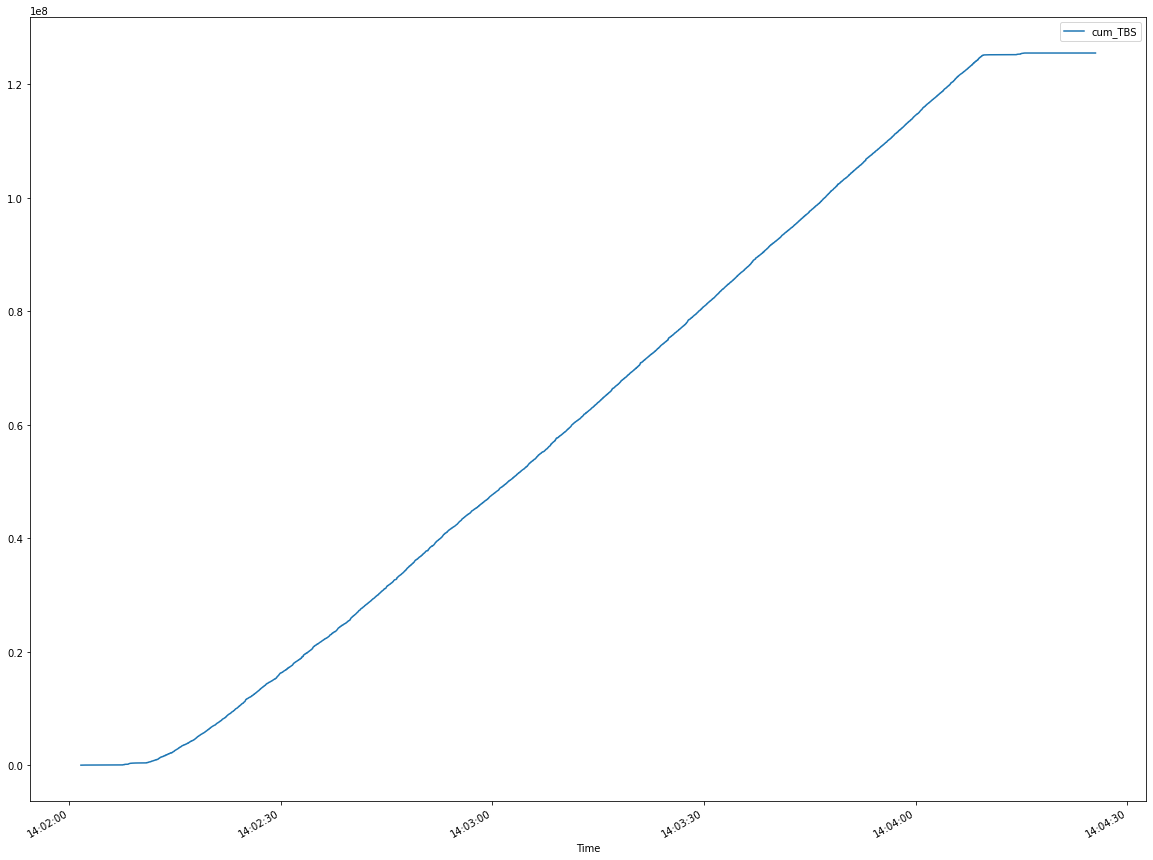

In [8]:
plot_data(current_data)

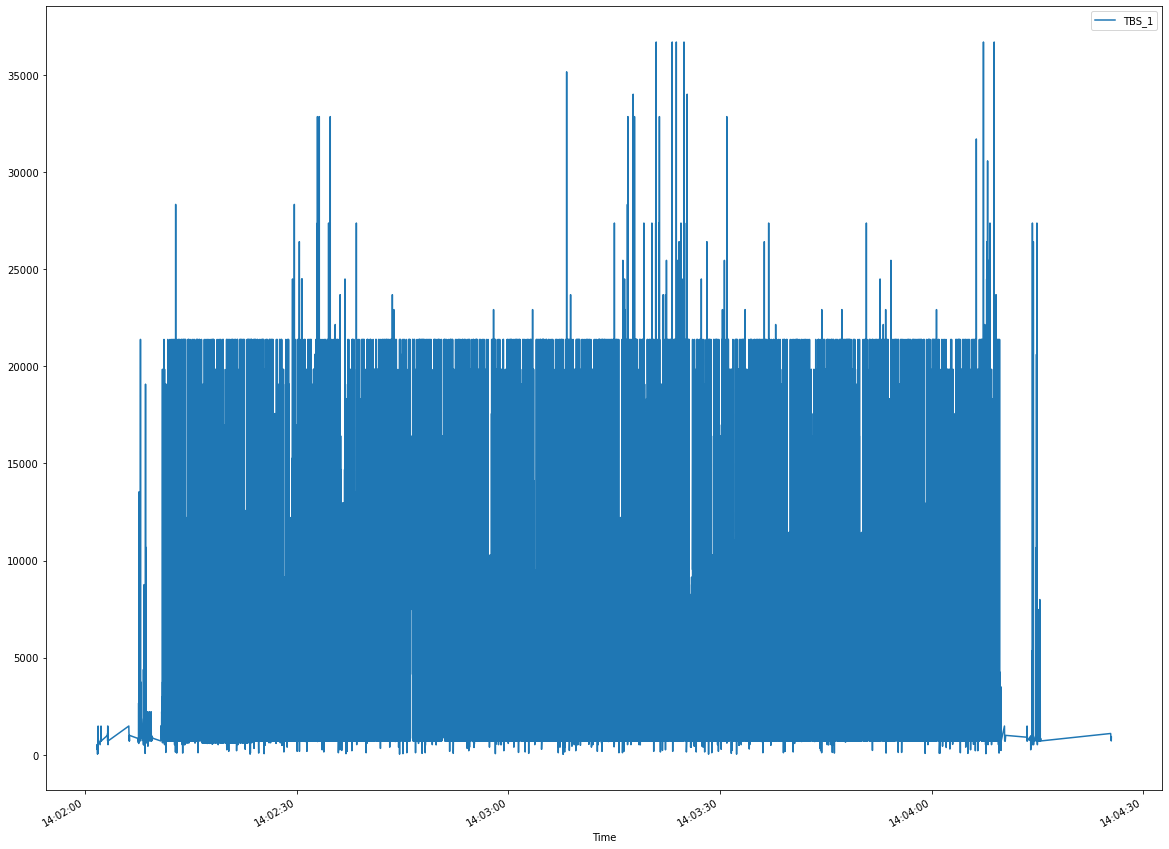

In [9]:
plot_data(current_data,y="TBS_1")

In [10]:
current_data.TBS_1.describe()

count    20044.000000
mean      6263.423269
std       5873.632971
min         32.000000
25%       1064.000000
50%       5544.000000
75%       8760.000000
max      36696.000000
Name: TBS_1, dtype: float64

<AxesSubplot:>

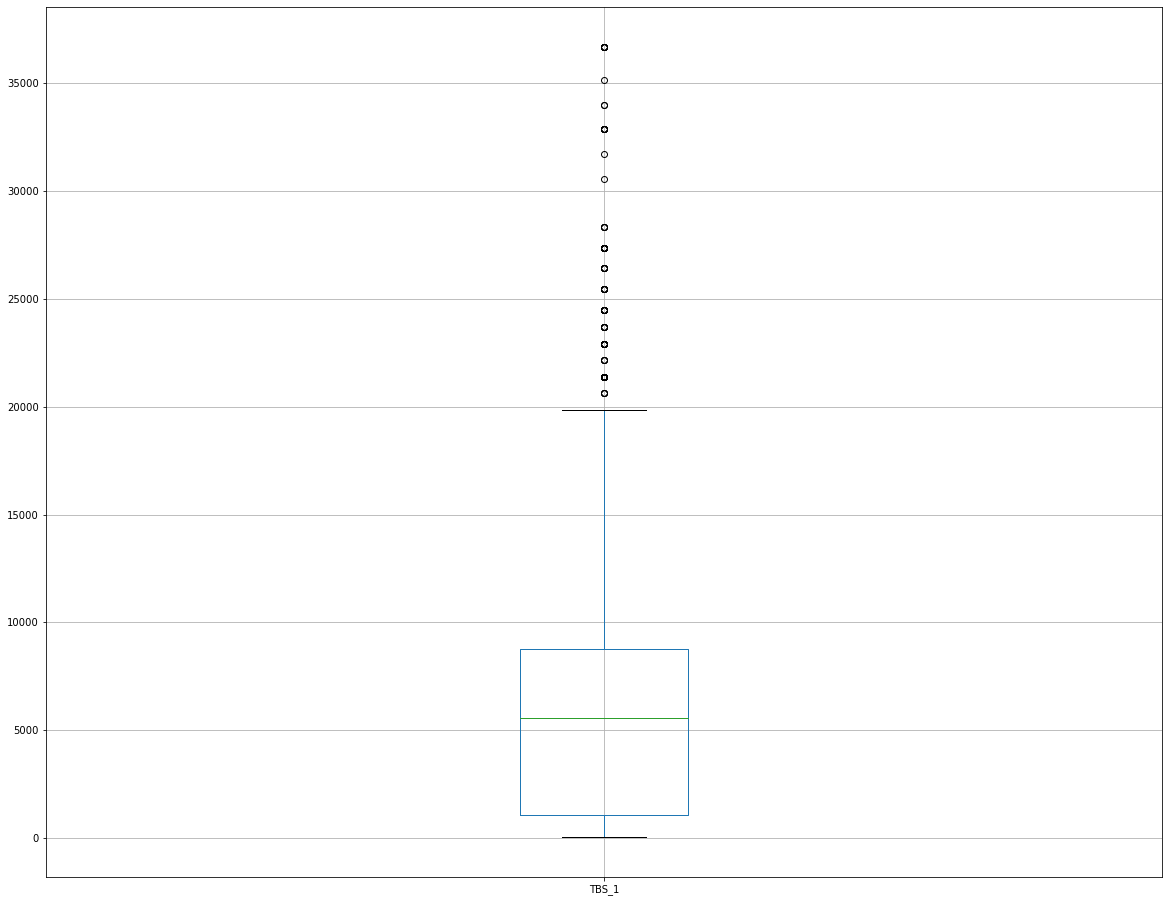

In [11]:
current_data[["TBS_1"]].boxplot()

# Tracé des différents connec_id

In [12]:
to_concat, col_TBS, col_TBS_sum = [], [], []
for value in data.connection_id.unique():
    tmp = data[data.connection_id==value]
    tmp[f"cum_TBS_conn_{value}"] = tmp["TBS_1"].cumsum()
    tmp[f"TBS_1_conn_{value}"] = tmp["TBS_1"]
    col_TBS.append(f"TBS_1_conn_{value}")
    col_TBS_sum.append(f"cum_TBS_conn_{value}")
    to_concat.append(tmp)
extended = pd.concat(to_concat)
extended

,Time,rnti,SFN,format,preamble,ta,nb_TB,MCSi_1,MCSi_2,TBS_1,TBS_2,nb_PRB,connection_id,cum_TBS,cum_TBS_conn_4,TBS_1_conn_4,cum_TBS_conn_5,TBS_1_conn_5
259,2022-10-14 14:02:01.662,80,3709,2.0,51.0,6.0,1,2,-2,296,-2,7,4,296,296.0,296.0,NaN,NaN
261,2022-10-14 14:02:01.677,80,3724,0.0,51.0,6.0,1,24,-2,520,-2,1,4,816,816.0,520.0,NaN,NaN
263,2022-10-14 14:02:01.693,80,3740,0.0,51.0,6.0,1,31,-2,520,-2,1,4,1336,1336.0,520.0,NaN,NaN
265,2022-10-14 14:02:01.717,80,3764,0.0,51.0,6.0,1,24,-2,520,-2,1,4,1856,1856.0,520.0,NaN,NaN
267,2022-10-14 14:02:01.737,80,3784,0.0,51.0,6.0,1,24,-2,520,-2,1,4,2376,2376.0,520.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31907,2022-10-14 14:04:36.037,81,4484,0.0,32.0,5.0,1,20,-2,840,-2,2,5,29928,NaN,NaN,29928.0,840.0
31910,2022-10-14 14:04:36.045,81,4492,0.0,32.0,5.0,1,24,-2,520,-2,1,5,30448,NaN,NaN,30448.0,520.0
31911,2022-10-14 14:04:36.050,81,4497,2.0,32.0,5.0,1,28,-2,712,-2,1,5,31160,NaN,NaN,31160.0,712.0
31915,2022-10-14 14:04:36.077,81,4524,0.0,32.0,5.0,1,20,-2,840,-2,2,5,32000,NaN,NaN,32000.0,840.0


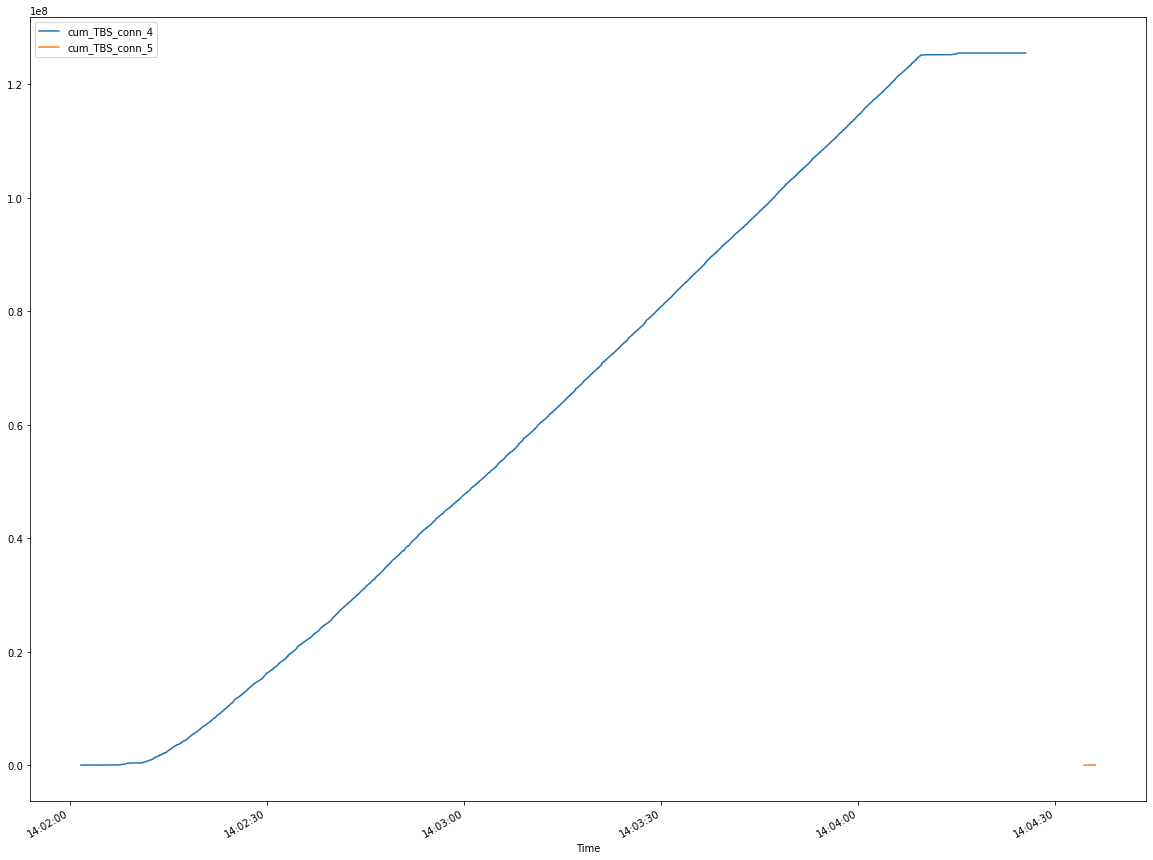

In [13]:
plot_data(extended, y=col_TBS_sum)

# First models

In [14]:
# 'whats.csv', 'yt.csv', 'yt_whats.csv'*


data1 = pd.read_csv('yt_whats.csv')
data2 = pd.read_csv('yt.csv')
data3 = pd.read_csv('whats.csv')


time_series = []
time_series.append((data1[data1.connection_id == 4].TBS_1,"yt"))
time_series.append((data1[data1.connection_id == 5].TBS_1,"noise"))
time_series.append((data1[data1.connection_id == 6].TBS_1,"WA"))

time_series.append((data2[data2.connection_id == 4].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 5].TBS_1,"yt"))
time_series.append((data2[data2.connection_id == 6].TBS_1,"yt"))
                   
time_series.append((data3[data3.connection_id == 4].TBS_1,"whats"))
time_series.append((data3[data3.connection_id == 5].TBS_1,"noise"))


time_series = [(ser[0].reset_index(drop=True),ser[1]) for ser in time_series]

time_series = [pd.DataFrame({f"{ser[1]}_{i}" : ser[0]} ) for i, ser in enumerate(time_series)]


#time_series
init_data = pd.concat(time_series, axis = 1)
init_data

,yt_0,noise_1,WA_2,yt_3,yt_4,yt_5,whats_6,noise_7
0,296.0,296.0,296.0,296.0,296.0,296.0,296,296.0
1,408.0,336.0,520.0,336.0,224.0,520.0,520,520.0
2,72.0,72.0,72.0,336.0,224.0,520.0,520,72.0
3,72.0,72.0,72.0,72.0,72.0,72.0,520,72.0
4,32.0,32.0,32.0,72.0,72.0,72.0,520,32.0
...,...,...,...,...,...,...,...,...
20039,NaN,NaN,NaN,NaN,NaN,NaN,840,NaN
20040,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN
20041,NaN,NaN,NaN,NaN,NaN,NaN,1096,NaN
20042,NaN,NaN,NaN,NaN,NaN,NaN,712,NaN


In [38]:
# to apply for each time serie



# format data : 
# 2 colonne = 1time series ( valeurs de TBS + son cumsum ), name col = "{label}_{val or sum}_id"
# les lignes = time codes ( on commence à 0 pour toutes)

def pass_trhough_first_layer(data) :
    list_rows = []
    for i in range(len(data.columns)) : # Pour chaque time serie
        useful_columns = data.columns[i]
        new_row = first_layer(data[useful_columns])
        
        new_row["label"] = useful_columns.split("_")[0]
        list_rows.append(new_row)
    data_final = pd.DataFrame.from_records(list_rows)
        
    
    # concatenate new rows  
    # return concatenation
    
    
    return data_final
    

def first_layer(data):
    metrics = {}
    cum_data = data.cumsum()
    
    
    
    
    # apply scaler
    
    # Here we apply models on cumulated sum
    models = ["reg_lin", "reg_iso", "reg_pol"]
    
    for model in models : 
        
        metrics = apply_simple_model(model, cum_data, metrics)
        
    # Here we can measure other metrics on none cumulated sum
    
    return metrics
    
    
    
    
        
    
def apply_simple_model(model, data, metrics) :
    current_data = data.dropna()
    #print(current_data.index.values.reshape(-1, 1))
    X = current_data.index.values.reshape(-1, 1)
    y = current_data.values
    
    if model =="reg_lin" :
        
        reg = LinearRegression()
        reg.fit(X, y)
        
        metrics["reg_lin_R2"] = reg.score(X, y)
        metrics["reg_lin_coef_A"] = reg.coef_[0]
        
    
    elif model =="reg_iso" :
        
        
        pass
    
    elif model == "reg_pol" :
        
        iso_reg = IsotonicRegression(increasing = True)
        iso_reg.fit(X, y)
        
        metrics["reg_iso_R2"] = iso_reg.score(X, y) # non fonctionnel
        
        if False :
            print("\n")
            print("params iso reg ", iso_reg.get_params(deep=True))
            print(iso_reg.X_thresholds_)
            print(iso_reg.y_thresholds_)
            print(len(iso_reg.X_thresholds_))
            print(len(iso_reg.y_thresholds_)," / ", len(y))
    
    
    return metrics
    
    
def apply_classifier(metrics_data,model = "KNN", test = True) :
    #print(list(metrics_data.columns[:-1]))
    x_train_unscaled = metrics_data[list(metrics_data.columns[:-1])].values
    y_train = metrics_data["label"]
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train_unscaled)
    
    
    if test : 
        x_train, x_test, y_train, y_test = train_test_split(x_train, y_test, test_size=0.2,random_state=100)
        
    
    
    if model == "KNN" :
        
        
        knn = KNeighborsClassifier()
        k_range = list(range(1, 31))
        param_grid = dict(n_neighbors=k_range)
        cv = min(10, int(x_train.shape[0]/3))
        grid = GridSearchCV(knn, param_grid, cv=cv, scoring='accuracy', return_train_score=False,verbose=1)

        grid_search=grid.fit(x_train, y_train)
        accuracy = grid_search.best_score_ *100
        print("Accuracy for our training dataset with tuning is : {:.2f}%".format(accuracy) )

    
    elif model == "Random_Forest":
        pass
    
    
    

In [39]:
new_data = pass_trhough_first_layer(init_data)
new_data

,reg_lin_R2,reg_lin_coef_A,reg_iso_R2,label
0,0.990482,17906.283145,1.0,yt
1,0.904971,2401.120839,1.0,noise
2,0.999669,6536.525202,1.0,WA
3,0.988323,20197.112974,1.0,yt
4,0.998063,29681.483128,1.0,yt
5,0.996474,29563.832155,1.0,yt
6,0.999779,6416.721630,1.0,whats
7,0.986697,1007.776197,1.0,noise


In [40]:
#quite good, le coef de reg lin permet deja de deviner la classe
# whatsapp a aussi les meilleurs R2 de reg lin >0.9995
# La ou yt on est sur : 0.985 -> 0.998
# noise très faible coeff, et R2 faible

In [41]:
apply_classifier(new_data ,model = "KNN", test = False)

Fitting 2 folds for each of 30 candidates, totalling 60 fits
Accuracy for our training dataset with tuning is : 62.50%
